### imports

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import env
from utils import (KaggleCameraDataset, one_hot_decision_function, 
                   unhot, softmax, inv_softmax, progress_iter, RNG, float32)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## useful routines

In [81]:
def get_proba(proba_path):
    return pd.read_csv(proba_path).as_matrix(columns=map(str, range(10)))


def avg_proba(*proba_matrices, **kwargs):
    #return np.exp(np.average([np.log(1e-16 + get_proba(path)) for path in proba_paths], axis=0, weights=kwargs.get('weights', None)))
    P = softmax(np.average([inv_softmax(P) for P in proba_matrices], axis=0, weights=kwargs.get('weights', None)))
#     P = np.average(proba_matrices, axis=0, weights=kwargs.get('weights', None))
    return P


def avg_proba_paths(*proba_paths, **kwargs):
    return avg_proba(*map(get_proba, proba_paths), **kwargs)


def proba_to_subm(proba, subm_path):
    """
    Parameters
    ----------
    proba : (2640, 10) np.ndarray
    """
    test_dataset = KaggleCameraDataset('../data/', train=False, lazy=True)
    fnames = [os.path.split(fname)[-1] for fname in test_dataset.X]
    index_pred = unhot(one_hot_decision_function(proba))
    data = {'fname': fnames,
            'camera': [KaggleCameraDataset.target_labels()[int(c)] for c in index_pred]}
    df = pd.DataFrame(data, columns=['fname', 'camera'])
    df.to_csv(subm_path, index=False)
    

def get_diff(subm_path1, subm_path2):
    df1 = pd.read_csv(subm_path1)
    df2 = pd.read_csv(subm_path2)
    return (df1 != df2)['camera'].sum()/2640.

In [4]:
P = get_proba('../models/proba1.csv')
P[:3, :3]

array([[  2.30427057e-01,   4.84325022e-01,   5.16182883e-03],
       [  4.63270843e-02,   1.69466971e-03,   1.10656278e-04],
       [  1.59370884e-01,   1.33133292e-01,   2.71781767e-03]])

## #1 average different predictions (from raw probs)

In [6]:
Q = avg_proba('../models/proba1.csv', 
              '../models/proba_best.csv', 
               weights=[1., 1.])
Q

array([[  1.30430266e-01,   4.46921155e-01,   3.23994139e-02, ...,
          1.20126526e-03,   1.05716349e-02,   6.87616952e-02],
       [  3.24848127e-02,   8.78940028e-02,   4.32265330e-03, ...,
          8.78389790e-04,   6.59955412e-01,   4.10077199e-02],
       [  1.20631762e-01,   1.52186640e-01,   1.57862445e-03, ...,
          1.04656043e-03,   1.19606800e-01,   5.12661040e-01],
       ..., 
       [  1.16247602e-01,   4.08802994e-01,   5.17931608e-02, ...,
          3.80601780e-02,   1.16218922e-02,   1.64976966e-01],
       [  4.96196985e-01,   4.23220114e-03,   2.48291728e-03, ...,
          3.88299840e-01,   1.79937498e-02,   6.91680338e-02],
       [  2.15672876e-01,   3.66537021e-02,   2.02466367e-03, ...,
          1.86312740e-05,   3.95222452e-02,   1.85410858e-02]])

## #2 convert proba to predictions

In [8]:
proba_to_subm(Q, 'subm.csv')

## #3 how predictions differ

In [10]:
get_diff('../models/submission1.csv', '../models/submission_best.csv')

/usr/local/lib/python2.7/dist-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


0.4693181818181818

# ensembles, yesss

### generations 1+2 (manual weights) $\rightarrow$ 0.913

In [8]:
proba_dirs = [
    #
    ## 1th-generation
    ### 
    # DenseNet no augmentation (512x512 crops)
    (0.1, '0.579-#15'),
    # DenseNet + random horiz flips only
    (0.25, '0.691-#23-tta-horiz'),
    # DenseNet + random crops + aug + TTA x 10 + LR restart
    (0.25, '0.732-#23-tta10'),
    (1., '0.750-#25'),
    # ... but trained on 256x256 crops
    (1., '0.742-#36'),
    # ... but trained using Hinge Loss (512x512)
    (1., '0.750-#30'),
    # CNN_Small 1-FC no aug
    (0.25, '0.665-#39'),
    # CNN_Small 2-FC (using best TTA) + SGD-m
    (0.1, '0.517-#48'),
    #
    ## 2nd-generation
    ###
    (2.0, '0.859-d5-#95'), # ema.9 0.885 | RETEST WITH NEW TTA256 [+] -> 0.871
    (1.5, 'dh5-#98'),      # ema.9 0.841 | RETEST WITH NEW TTA64  [+]
    (1.5, 'r3-#100'),      # ema.9 0.845 | RETEST WITH NEW TTA64  [-]
    (2.0, 'R3-#103'),      # ema.9 0.877 | RETEST WITH NEW TTA128 [+]
    (1.0, 'c6-#105'),      # ema.9 0.791 | RETEST WITH NEW TTA32  [+]
    
#     # 3rd-generation
#     ## 
#     (0.75, 'dc1-#131'), # TTA64 | ema.9 0.9126
#     (1.0, 'dhc1-#132'), # TTA32 | ema.9 0.8822
#     (1.0, 'D1-#135'),   # TTA32 | ema.9 ~0.89
#     (1.0, 'Rc1-#133'),  # TTA32 | ema.9 0.9004
#     (1.0, 'Z1-#134'),   # TTA32 | ema.9 0.8995
#     (0.5, 'cc1-#137'),  # TTA32 | ema.9 0.7948
]
weights, dirs = zip(*proba_dirs)
P = avg_proba(*map(lambda p: '../submissions/{0}/proba.csv'.format(p), dirs), 
              weights=list(weights))
proba_to_subm(P, '../submissions/averaged_gen12.csv')

[0.1, 0.25, 0.25, 1.0, 1.0, 1.0, 0.25, 0.1, 2.0, 1.5, 1.5, 2.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 0.5]


### generation 4

In [ ]:
    # D121 256x256 d=0 weighted
    '0.960-d-#181', 
#     # BEST FROM D121 d=0.3
#     '0.949-dw-0.3-#194',
#     # D121 512x512 d=0.1 (unw.)
#     '0.946-d-512-#191',
#     # R50 512x512 d=0.2 (unw.)
#     'R-512-#189',
#     # R50 256x256 d=0 (unw.)
#     ('R-#190'),
#     # TODO: C2 * 0.25

## generation 5 (bootstrapping) $\rightarrow$ 0.973

In [52]:
softmax(np.arange(10))**0.5

array([[ 0.00883252,  0.01456236,  0.02400928,  0.03958461,  0.06526399,
         0.10760213,  0.17740591,  0.2924929 ,  0.48223927,  0.79507815]])

In [54]:
softmax(np.arange(10)/2.) / (softmax(np.arange(10))**0.5)

array([[ 0.49823845,  0.49823845,  0.49823845,  0.49823845,  0.49823845,
         0.49823845,  0.49823845,  0.49823845,  0.49823845,  0.49823845]])

In [ ]:
# (d121/10., 'dp-0.2(0.9333)-#206'),
# (d121/10., 'dp-0.1-horiz(0.9333)-#205'),
(D201/2., 'Dp-0.3-fc@10(0.9354)-#209'),

proba_dirs = [
    (1., [
        (1./3., '0.965-dp-0.1-final-no-weighted-#220'),
        (1./3., '0.969-dp-0.1-#204'),
        (1./3., '0.970-dp-0.2-fc-#208'),
    ]),
    (1., [
        
        (1., 'Dp-0.25-fc(0.9500)-#224'),
    ]),
    (1., [
        (1./12., 'dp-final(0.9604)-#221'),
        (1./12., 'dp-0.05-final(0.9500)-#223'),
        (1./12., 'dp-0.1-bs(0.9521)-#228'),
        (1./12., 'dp-0.1-final(0.9563)-#219'),
        (1./12., 'dp-0.1-adam(0.9542)-#218'),
        (1./12., 'dp-0.1-final-bag-1'),
        (1./12., 'dp-0.1-final-bag-2'),
        (1./12., 'dp-0.1-final-bag-3'),
        (1./12., 'dp-0.1-final-bag-4'),
        (1./12., 'dp-0.1-final-bag-5'),
        (1./12., 'dp-0.1-final-bag-6'),
        (1./12., 'dp-0.1-final-bag-7'),
    ])    
]

In [82]:
# (d121/10., ),
# (d121/10., ),
# (D201/2., 'Dp-0.3-fc@10(0.9354)-#209'),

proba_dirs = [
    (1./3., [
        (1., '0.965-dp-0.1-final-no-weighted-#220'),
        (1., '0.969-dp-0.1-#204'),
        (1., '0.970-dp-0.2-fc-#208'),
    ]),
    (1./2., [
        (1., 'Dp-0.15-fc(0.9500)-#213'),
        (1., 'Dp-0.25-fc(0.9500)-#224'),
    ]),
    (1./2., [
        (1., 'R152p-0.15-fc(0.9458)-#216'),
        (1., 'R152p-0.25-fc(0.9521)-#227'),
    ]),
    (1./4., [
        (1., 'RX64p-0.1(0.9521)-#217'),
        (1., 'RX64p-0.2-fc(0.9583)-#226'),
        (1., 'RXp-0.1(0.9500)-#215'),
        (1., 'RXp-0.2-fc(0.9479)-#225')
    ]),
    (1./12., [
        (1., 'dp-final(0.9604)-#221'),
        (1., 'dp-0.05-final(0.9500)-#223'),
        (1., 'dp-0.1-bs(0.9521)-#228'),
        (1., 'dp-0.1-final(0.9563)-#219'),
        (1., 'dp-0.1-adam(0.9542)-#218'),
        (1., 'dp-0.1-final-bag-1'),
        (1., 'dp-0.1-final-bag-2'),
        (1., 'dp-0.1-final-bag-3'),
        (1., 'dp-0.1-final-bag-4'),
        (1., 'dp-0.1-final-bag-5'),
        (1., 'dp-0.1-final-bag-6'),
        (1., 'dp-0.1-final-bag-7'),
    ])    
]

proba_dirs_normalized = []
for meta_w, dirs in proba_dirs:
    for w, d in dirs:
        proba_dirs_normalized.append((meta_w * w, d))
proba_dirs = proba_dirs_normalized

y_val = np.load('../submissions/{0}/y_val.npy'.format(proba_dirs[0][1]))
def val_acc(z):
    return sum(z.argmax(axis=1) == y_val)/float(len(y_val))

X = []

for w, path in proba_dirs:
    logits = np.load('../submissions/{0}/logits_val.npy'.format(path))
    X.append((w, logits))

def g(x):
    return np.sqrt(np.abs(x))*np.sign(x)
    
w, X = zip(*X)
X = np.asarray(X) # logits
Y = X.copy()
print "1) Arithmetic (proba)    \t{0:.4f}".format(val_acc(np.average([softmax(y) for y in Y], axis=0, weights=w)))
print "2) Geometric (avg. logits)\t{0:.4f}".format(val_acc(np.average([y for y in Y], axis=0, weights=w)))
print "3) proba ** 0.5\t\t\t{0:.4f}".format(val_acc(np.average([softmax(y)**0.5 for y in Y], axis=0, weights=w)))
print "3) proba ** 2\t\t\t{0:.4f}".format(val_acc(np.average([softmax(y)**2. for y in Y], axis=0, weights=w)))
print "[x] g(logits)\t\t\t{0:.4f}".format(val_acc(np.average([g(y) for y in Y], axis=0, weights=w)))
print "5) softmax(g(logits))\t\t{0:.4f}".format(val_acc(np.average([softmax(g(y)) for y in Y], axis=0, weights=w)))
    
weights, dirs = zip(*proba_dirs)
P = avg_proba_paths(*map(lambda p: '../submissions/{0}/proba.csv'.format(p), dirs), weights=list(weights))
proba_to_subm(P, '../submissions/avg-submission.csv');

1) Arithmetic (proba)    	0.9833
2) Geometric (avg. logits)	0.9812
3) proba ** 0.5			0.9812
3) proba ** 2			0.9792
[x] g(logits)			0.9771
5) softmax(g(logits))		0.9792


## generation 4+5th

In [50]:
dirs = [
    # w/o pseudo-labels
#     '0.960-d-#181',
    # w/ pseudo-labels
    '0.965-dp-0.1-final-no-weighted-#220',
    '0.969-dp-0.1-#204',
    '0.970-dp-0.2-fc-#208',
    # <ALL FROM 
]
P = avg_proba_paths(*map(lambda p: '../submissions/{0}/proba.csv'.format(p), dirs))
proba_to_subm(P, '../submissions/#236-submission.csv');

### ($\approx$blending) $\rightarrow$ 0.968 (overfit to val. set)

In [51]:
dirs = [
    # w/o pseudo-labels
#     '0.960-d-#181',
    # w/ pseudo-labels
    '0.965-dp-0.1-final-no-weighted-#220',
    '0.969-dp-0.1-#204',
    '0.970-dp-0.2-fc-#208',
    # <ALL FROM 
]

X = []
manip = np.load('../submissions/{0}/manip_val.npy'.format(dirs[0]))
y = np.load('../submissions/{0}/y_val.npy'.format(dirs[0]))
for d in dirs:
#     X_b = softmax(np.load('../submissions/{0}/logits_val.npy'.format(d)))
    X_b = np.load('../submissions/{0}/logits_val.npy'.format(d))
    X_b -= X_b.mean(axis=1)[:, np.newaxis]
    X.append(X_b)
X = [manip] + X
X = np.hstack(X)
X.shape, y.shape

((480, 31), (480,))

### just average predictions

In [25]:
print sum(X[0].argmax(axis=1) == y) / 480.
print sum(X[1].argmax(axis=1) == y) / 480.
print sum(X[2].argmax(axis=1) == y) / 480.
print "Avg", sum(((X[0] + X[1] + X[2])/3.).argmax(axis=1) == y) / 480.
print "Geomean", sum(avg_proba(X[0], X[1], X[2]).argmax(axis=1) == y) / 480.

0.966666666667
0.975
0.964583333333
Avg 0.975
Geomean 0.76875


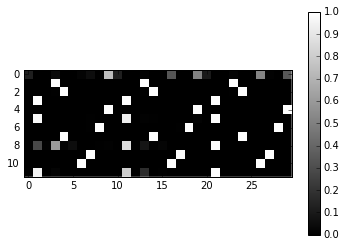

In [7]:
plt.imshow(X[:12,1:], cmap='gray', interpolation='none');
plt.colorbar();

### grid search logreg

In [52]:
# TODO: for train use solver 'sag', 'saga' everywhere
logreg = LogisticRegression(tol=1e-5, max_iter=1000,
                            class_weight='balanced')
logreg_cv = GridSearchCV(estimator=logreg,
                         param_grid=[{'C': np.logspace(-4, 8, 13), 'multi_class': ['ovr'], 'solver': ['liblinear']},
                                     {'C': np.logspace(-4, 8, 13), 'multi_class': ['multinomial'], 'solver': ['lbfgs', 'sag', 'saga']}],
                         verbose=1,
                         n_jobs=-1,
                         cv=10)
logreg_cv.fit(X, y);

Fitting 10 folds for each of 52 candidates, totalling 520 fits


[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 382 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 520 out of 520 | elapsed:  2.0min finished


In [53]:
print logreg_cv.best_score_
print logreg_cv.best_params_
pd.DataFrame(logreg_cv.cv_results_).head()

0.989583333333
{'multi_class': 'multinomial', 'C': 100000.0, 'solver': 'saga'}


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_multi_class,param_solver,params,rank_test_score,split0_test_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.019597,0.000480,0.975000,0.975470,0.0001,ovr,liblinear,"{u'multi_class': u'ovr', u'C': 0.0001, u'solve...",32,0.98,...,0.98,0.974419,0.975,0.975000,1.0,0.972727,0.005771,0.000147,0.023496,0.002900
1,0.034619,0.000422,0.968750,0.972230,0.001,ovr,liblinear,"{u'multi_class': u'ovr', u'C': 0.001, u'solver...",41,0.96,...,0.98,0.972093,0.975,0.970455,1.0,0.970455,0.006005,0.000161,0.022185,0.001637
2,0.049029,0.000388,0.972917,0.976860,0.01,ovr,liblinear,"{u'multi_class': u'ovr', u'C': 0.01, u'solver'...",36,0.96,...,0.98,0.976744,0.975,0.975000,1.0,0.975000,0.001329,0.000040,0.022028,0.002858
3,0.075200,0.000383,0.972917,0.992595,0.1,ovr,liblinear,"{u'multi_class': u'ovr', u'C': 0.1, u'solver':...",36,0.94,...,0.98,0.995349,0.975,0.993182,1.0,0.990909,0.017963,0.000023,0.017849,0.002013
4,0.082657,0.000396,0.979167,0.997680,1,ovr,liblinear,"{u'multi_class': u'ovr', u'C': 1.0, u'solver':...",30,0.94,...,0.98,0.997674,0.975,1.000000,1.0,0.997727,0.005767,0.000015,0.020242,0.001040


### grid search SVM

In [30]:
svc = SVC(tol=1e-6, max_iter=-1, class_weight='balanced')
svc_cv = GridSearchCV(estimator=svc,
                      param_grid={'kernel': ['linear', 'rbf'],
                                  'C': np.logspace(-4, 8, 13),
                                  'decision_function_shape': ['ovr', 'ovo']},
                      verbose=1,
                      n_jobs=-1,
                      cv=10)
svc_cv.fit(X, y);

Fitting 10 folds for each of 52 candidates, totalling 520 fits


[Parallel(n_jobs=-1)]: Done 348 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 520 out of 520 | elapsed:    6.5s finished


In [31]:
print svc_cv.best_score_
print svc_cv.best_params_
pd.DataFrame(svc_cv.cv_results_).head()

0.985416666667
{'kernel': 'linear', 'C': 0.01, 'decision_function_shape': 'ovr'}


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_decision_function_shape,param_kernel,params,rank_test_score,split0_test_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.015002,0.001839,0.945833,0.946771,0.0001,ovr,linear,"{u'kernel': u'linear', u'C': 0.0001, u'decisio...",25,0.90,...,0.96,0.944186,0.950,0.945455,1.000,0.943182,0.007096,0.001576,0.035697,0.003537
1,0.039595,0.003307,0.477083,0.923155,0.0001,ovr,rbf,"{u'kernel': u'rbf', u'C': 0.0001, u'decision_f...",45,0.32,...,0.40,0.893023,0.525,0.886364,0.725,0.956818,0.005923,0.001954,0.103460,0.026829
2,0.010377,0.002087,0.945833,0.946771,0.0001,ovo,linear,"{u'kernel': u'linear', u'C': 0.0001, u'decisio...",25,0.90,...,0.96,0.944186,0.950,0.945455,1.000,0.943182,0.002347,0.003091,0.035697,0.003537
3,0.043459,0.002521,0.477083,0.923155,0.0001,ovo,rbf,"{u'kernel': u'rbf', u'C': 0.0001, u'decision_f...",45,0.32,...,0.40,0.893023,0.525,0.886364,0.725,0.956818,0.018340,0.000169,0.103460,0.026829
4,0.006535,0.000658,0.966667,0.973145,0.001,ovr,linear,"{u'kernel': u'linear', u'C': 0.001, u'decision...",23,0.94,...,0.98,0.972093,0.950,0.975000,1.000,0.972727,0.003142,0.000021,0.024438,0.002156


In [54]:
clf = logreg_cv.best_estimator_

X_test = []
manip_test = map(lambda s: int('_manip' in s), KaggleCameraDataset('../data/', train=False).X)
manip_test = np.array(manip_test, dtype=np.float).reshape((-1, 1))
for d in dirs:
    X_b = inv_softmax(get_proba('../submissions/{0}/proba.csv'.format(d)))
    X_test.append(X_b)
X_test = [manip_test] + X_test
X_test = np.hstack(X_test)
P_test = clf.predict_proba(X_test)

proba_to_subm(P_test, '../submissions/#237-submission.csv')

## average all approaches

In [ ]:
proba_dirs = [
    #
    ##
    ### generations 1, 2
    (1., '0.913-#109-recomp'),   
]

weights, dirs = zip(*proba_dirs)
P = avg_proba(*map(lambda p: '../submissions/{0}/proba.csv'.format(p), dirs), 
              weights=list(weights))
proba_to_subm(P, '../submissions/all_averaged.csv')

# pseudo-labels[2]

In [11]:
P = get_proba('../submissions/0.960-d-#181/proba.csv')
THRESHOLD = 0.99
pseudo_ind = {}
for c in xrange(10):
    c_ind = np.arange(len(P))[P[:,c] > THRESHOLD].tolist()
    c_ind.sort(key=lambda i: -P[i, c]) # sorted such that c_ind[0] is the most confident image
    pseudo_ind[c] = c_ind
print map(len, pseudo_ind.values())

[248, 103, 237, 242, 236, 252, 251, 206, 223, 229]


In [12]:
pseudo_ind[0][:5]

[1742, 361, 1386, 963, 2436]

In [13]:
pseudo_ind[7][:3]

[2138, 2171, 2220]

In [14]:
with open('../data/pseudo_ind.json', 'w') as f:
    json.dump(pseudo_ind, f, indent=4, sort_keys=True)

In [31]:
with open('../data/pseudo_ind.json') as f:
    pseudo_ind = json.load(f)

In [28]:
pseudo_ind['0'][:5]

[1742, 361, 1386, 963, 2436]

### load and save most confident images for validation

In [18]:
test_dataset = KaggleCameraDataset('../data/', train=False)

In [19]:
N_PSEUDO_VAL_PER_CLASS = 24
N_PSEUDO_VAL = N_PSEUDO_VAL_PER_CLASS * 10
X_pseudo_val = np.zeros((N_PSEUDO_VAL, 512, 512, 3), dtype=np.uint8)

pos = 0
y_pseudo_val = []
manip = []
for c in xrange(10):
    for i in pseudo_ind[str(c)][:N_PSEUDO_VAL_PER_CLASS]:
        (x, m), _ = test_dataset[i]
        X_pseudo_val[pos] = np.asarray(x, dtype=np.uint8)
        pos += 1
        manip.append(m)
        y_pseudo_val.append(c)

### merge with existing validation, shuffle and save

In [84]:
X_val_val = np.load('../data/X_val_val.npy')
y_val_val = np.load('../data/y_val_val.npy')

In [85]:
X_val_with_pseudo = np.concatenate((X_val_val, X_pseudo_val))
print X_val_with_pseudo.shape, X_val_with_pseudo.dtype

(480, 512, 512, 3) uint8


In [86]:
y_val_with_pseudo = np.concatenate((y_val_val, np.asarray(y_pseudo_val)))
print y_val_with_pseudo.shape, y_val_with_pseudo.dtype

(480,) int64


In [87]:
manip_with_pseudo = np.concatenate((np.asarray([float32(0.)]*len(y_val_val)), manip))
print manip_with_pseudo.shape, manip_with_pseudo.dtype

(480, 1) float32


In [90]:
ind = np.arange(480)
RNG(seed=1234).shuffle(ind)
X_val_with_pseudo = X_val_with_pseudo[ind]
y_val_with_pseudo = y_val_with_pseudo[ind]
manip_with_pseudo = manip_with_pseudo[ind]
np.save('../data/X_val_with_pseudo.npy', X_val_with_pseudo)
np.save('../data/y_val_with_pseudo.npy', y_val_with_pseudo)
np.save('../data/manip_with_pseudo.npy', manip_with_pseudo)

In [97]:
sum(manip_with_pseudo)

array([ 68.], dtype=float32)

In [102]:
float32(0.)[0] < 0.1

True

### remaining pseudo-labels for training

In [32]:
for c in xrange(10):
    pseudo_ind[c] = pseudo_ind[str(c)][N_PSEUDO_VAL_PER_CLASS:]
    del pseudo_ind[str(c)]
PSEUDO_CLASSES = map(len, pseudo_ind.values())
PSEUDO_CLASSES

[224, 79, 213, 218, 212, 228, 227, 182, 199, 205]

#### split into blocks of 8 images and save like regular train

In [33]:
PSEUDO_BLOCK_SIZE = 8
N_PSEUDO_BLOCKS = [int(np.round(t/float(PSEUDO_BLOCK_SIZE))) for t in PSEUDO_CLASSES]
N_PSEUDO_BLOCKS

[28, 10, 27, 27, 26, 28, 28, 23, 25, 26]

In [ ]:
for c in xrange(10):
    c_ind = pseudo_ind[c]
    RNG(seed=8888 + c).shuffle(c_ind)
    class_blocks = []
    class_manip = []
    for _ in xrange(N_PSEUDO_BLOCKS[c]):
        class_blocks.append([])
        class_manip.append([])
    pos = 0
    for i in progress_iter(c_ind, True):
        (x, m), _ = test_dataset[i]
        x = np.asarray(x, dtype=np.uint8)
        class_blocks[pos % N_PSEUDO_BLOCKS[c]].append(x)
        class_manip[pos % N_PSEUDO_BLOCKS[c]].append(m)
        pos += 1
    for b in xrange(N_PSEUDO_BLOCKS[c]):
        np.save('../data/X_pseudo_{0}_{1}.npy'.format(c, b), np.asarray(class_blocks[b], dtype=np.uint8))
        np.save('../data/manip_pseudo_{0}_{1}.npy'.format(c, b), np.asarray(class_manip[b], dtype=np.float32))

### manip ratio

In [40]:
manip = []
for c in xrange(10):
    c_ind = pseudo_ind[c]
    for i in c_ind:
        (_, m), _ = test_dataset[i]
        manip.append(m)
print len(manip)
print sum(manip)

1987
[ 972.]


# pseudo-labels

In [32]:
# P from 0.908-#109
ind = np.arange(2640)[P.max(axis=1) > 0.8]
print len(ind)

835


In [49]:
test_data = KaggleCameraDataset('../data/', train=False)
X = np.zeros((len(ind), 512, 512, 3), dtype=np.uint8)
pos = 0
for i in ind:
    x = Image.open(test_data.X[i])
    x = np.array(x, dtype=np.uint8)
    X[pos, ...] = x
    pos += 1
y = np.argmax(P, axis=1)[ind]

### stratifically split into ~335 for validation and 500 for training

In [55]:
sss = StratifiedShuffleSplit(n_splits=1, train_size=500, random_state=1337)
train_ind, val_ind = list(sss.split(X, y))[0]
print train_ind.shape

(500,)


In [57]:
np.save('../data/X_pseudo_train.npy', X[train_ind])
np.save('../data/y_pseudo_train.npy', y[train_ind])
np.save('../data/X_pseudo_val.npy', X[val_ind])
np.save('../data/y_pseudo_val.npy', y[val_ind])